In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# show mid-slices
def show3(v: np.ndarray, title=""):
    z, y, x = v.shape
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    axs[0].imshow(v[z//2], cmap="gray"); axs[0].set_title("Axial")
    axs[1].imshow(v[:,y//2,:], cmap="gray"); axs[1].set_title("Coronal")
    axs[2].imshow(v[:,:,x//2], cmap="gray"); axs[2].set_title("Sagittal")
    for a in axs: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()
raw_tesla = tiff.imread("../data/Tesla.tif").astype(np.float32)
raw_litarion = tiff.imread("../data/Litarion.tif").astype(np.float32)
raw_nanotek = tiff.imread("../data/Nanotek_GCA2000.tif").astype(np.float32)
raw_sony = tiff.imread("../data/Sony_VTC5.tif").astype(np.float32)

In [2]:
from typing import Tuple
from skimage.restoration import denoise_tv_chambolle
from typing import Optional
import SimpleITK as sitk
import numpy as np


def clip_and_scale(
    v: np.ndarray, pcts: Tuple[float, float] = (0.5, 99.5), eps: float = 1e-6
) -> Tuple[np.ndarray, float, float]:
    """Clip and scale a value to the range [0, 1] based on given percentiles.

    Args:
        v: The input value or array to be clipped and scaled.
        pcts: A tuple containing the lower and upper percentiles for clipping.
        eps: A small epsilon value to prevent division by zero.

    Returns:
        A list containing the clipped and scaled array,
        the lower percentile value, and the upper percentile value.
    """
    p1, p2 = np.percentile(v, pcts)

    if not np.isfinite(p1) or not np.isfinite(p2):
        raise ValueError("Percentiles are NaN/Inf")

    if p2 <= p1:
        scaled = np.zeros_like(v, dtype=np.float32)
        return scaled, float(p1), float(p2)
    else:
        clipped: np.ndarray = np.clip(v, p1, p2)
        scaled_v: np.ndarray = (clipped - p1) / (p2 - p1 + eps)
        scaled = scaled_v.astype(np.float32, copy=False)

    np.clip(scaled, 0.0, 1.0, out=scaled)
    return scaled, float(p1), float(p2)

def denoise_tv(volume: np.ndarray, weight: float=0.05, n_iter_max: int = 200, mask: Optional[np.ndarray] = None):
    v = volume.astype(np.float32, copy=False)
    
    if mask is None:
        out = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None,
        ).astype(np.float32, copy=False)
    else:
        den = denoise_tv_chambolle(
            v,
            weight=weight,
            max_num_iter=n_iter_max,
            channel_axis=None
        ).astype(np.float32, copy=False)
        out = v.copy()
        out[mask.astype(bool)] = den[mask.astype(bool)]
    
    np.clip(out, 0.0, 1.0, out=out)
    return out


Scaled to [0,1] using percentiles: -2.22e-06-1.62e-06
min, max, unique= -3.4975624e-06 2.668628e-06 [-3.4975624e-06 -3.4753218e-06 -3.4709017e-06 ...  2.6369062e-06
  2.6478174e-06  2.6686280e-06]


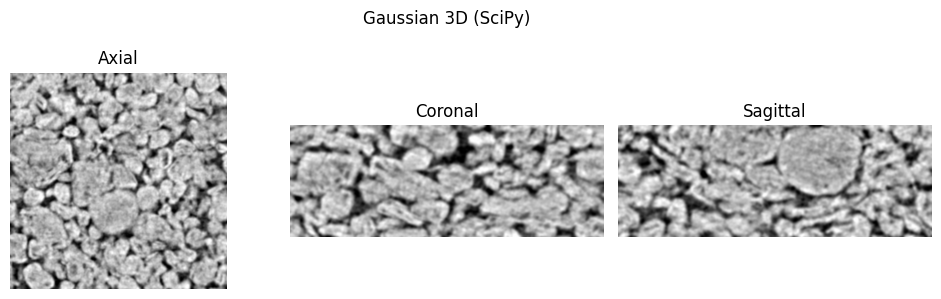

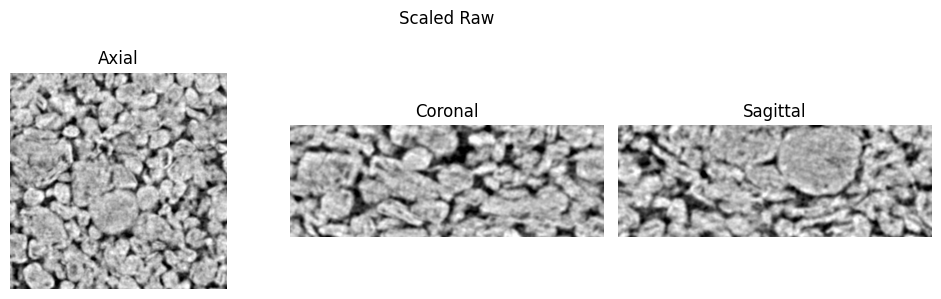

In [3]:
from tifffile import imread
from scipy.ndimage import gaussian_filter

v_raw = imread("../data/Litarion.tif")
v_scaled, p1, p2 = clip_and_scale(v_raw, pcts=(0.5, 99.5))

print(f"Scaled to [0,1] using percentiles: {p1:.2e}-{p2:.2e}")
print("min, max, unique=", np.min(v_raw), np.max(v_raw), np.unique(v_raw))

out_gauss = gaussian_filter(v_scaled, sigma=1.0)
show3(out_gauss, "Gaussian 3D (SciPy)")
show3(v_scaled, "Scaled Raw")


3D Multi-Otsu Segmentation with Interclass Variance
Segmentation results:
Thresholds: [0.33003193 0.5407566 ]
Classes: [0 1 2 3]
Voxel counts: [  129649 21348752 42304152 58717447]
Interclass Variance: 0.0235


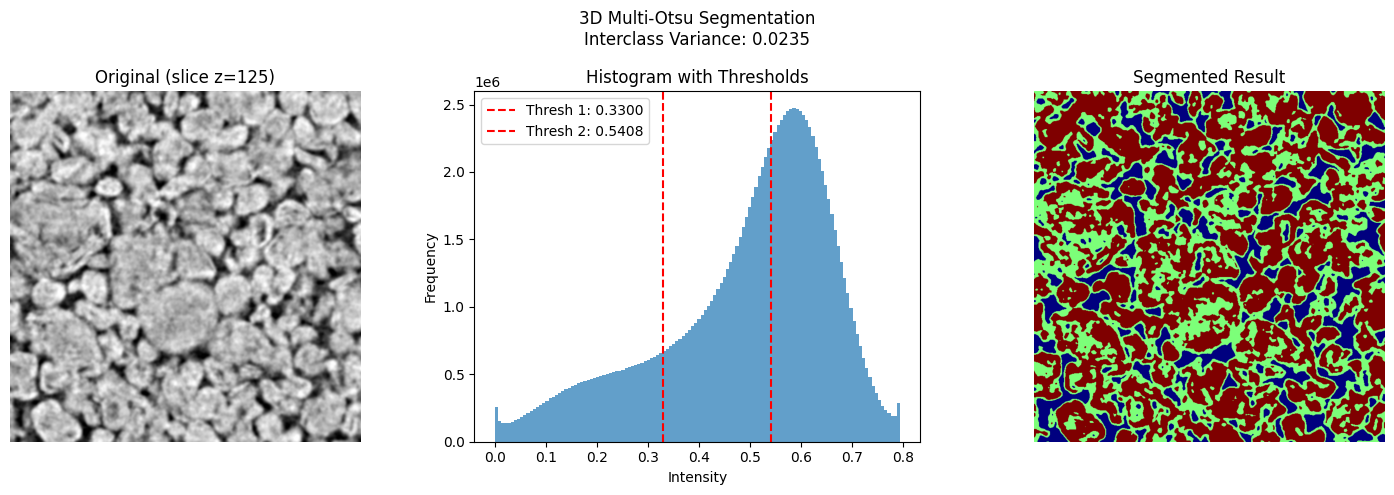

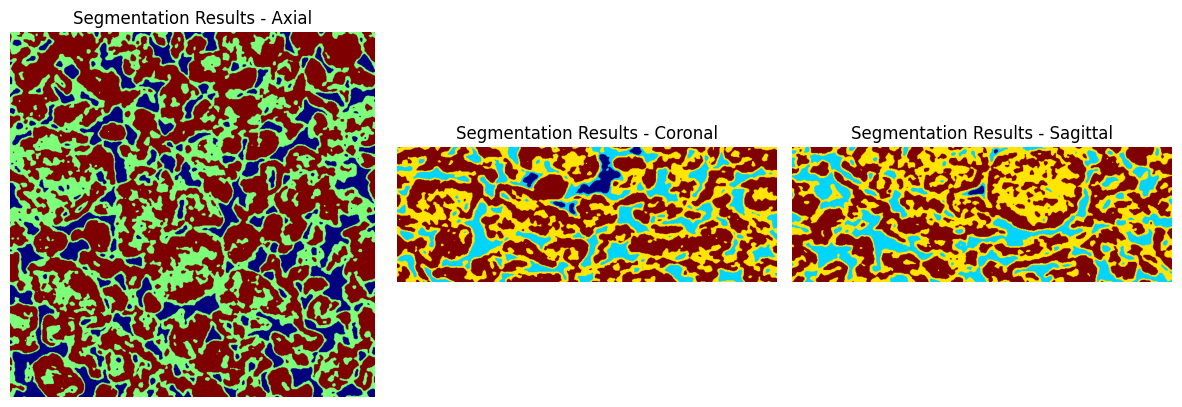

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu, threshold_otsu
from scipy import ndimage
from skimage.morphology import ball
from skimage.measure import label, regionprops


def multi_otsu_3d(volume: np.ndarray, classes: int = 3,
                  min_bg_size: int = 5000, max_bg_size: int = 20000):
    """
    function takes inn: 3D volume (XCT) and:
        Detects low-intensity background region
        Runs multi-otsu on the foreground only
        Assigns class labels to each voxel
        Computes interclass variance as a quality measure
    Returns thresholds, labeled volume, and interclass variance.
    """

    v = volume.astype(np.float32, copy=False)

    # Detect background using Otsu threshold
    try:
        otsu_threshold = threshold_otsu(v)
        background_threshold = otsu_threshold * 0.3
    except:
        background_threshold = np.percentile(v, 2)
# Compute global otsu thershold on the whole volume
    # Create background mask from largest low-intensity region
    low_intensity_mask = v < background_threshold
    background_mask = np.zeros_like(v, dtype=bool)

    if np.any(low_intensity_mask):
        labeled_mask, num_features = ndimage.label(low_intensity_mask)
        if num_features > 0:
            component_sizes = np.bincount(labeled_mask.ravel())
            if len(component_sizes) > 1:
                largest_component = np.argmax(component_sizes[1:]) + 1
                background_candidate = labeled_mask == largest_component

                # Apply size constraints
                region_size = component_sizes[largest_component]
                if min_bg_size <= region_size <= max_bg_size:
                    background_mask = ndimage.binary_dilation(background_candidate, structure=ball(1))
                else:
                    background_mask = low_intensity_mask

    # Segment only foreground regions
    foreground_mask = ~background_mask
    foreground_data = v[foreground_mask]

    if len(foreground_data) == 0:
        # Fallback if no foreground found
        thresholds = threshold_multiotsu(v, classes=classes)
        foreground_mask = np.ones_like(v, dtype=bool)
        foreground_data = v
    else:
        # Apply multi-Otsu to foreground
        thresholds = threshold_multiotsu(foreground_data, classes=classes)

    # Label the volume
    labeled_volume = np.zeros_like(v, dtype=np.uint8)

    # Background gets label 0
    labeled_volume[background_mask] = 0

    # Apply thresholds to foreground regions
    # Class 1: lowest intensity foreground
    mask = foreground_mask & (v <= thresholds[0])
    labeled_volume[mask] = 1

    # Middle classes
    for i in range(1, len(thresholds)):
        mask = foreground_mask & (v > thresholds[i-1]) & (v <= thresholds[i])
        labeled_volume[mask] = i + 1

    # Highest class
    mask = foreground_mask & (v > thresholds[-1])
    labeled_volume[mask] = len(thresholds) + 1

    # Calculate interclass variance
    # Use the class labels directly, not connected components
    unique_labels = np.unique(labeled_volume)
    class_means = []
    class_weights = []

    total_foreground_pixels = np.sum(foreground_mask)
    global_mean = np.mean(foreground_data)

    for label_val in unique_labels:
        if label_val == 0:  # Skip background
            continue
        mask = labeled_volume == label_val
        class_pixels = v[mask]
        if len(class_pixels) > 0:
            class_means.append(np.mean(class_pixels))
            class_weights.append(len(class_pixels) / total_foreground_pixels)

    interclass_variance = 0.0
    for weight, mean in zip(class_weights, class_means):
        interclass_variance += weight * (mean - global_mean) ** 2

    return thresholds, labeled_volume, interclass_variance




# Everything beneath is for outputs (visuals)

def show_segmentation_results(original_volume, segmented_volume, thresholds,
                            interclass_variance, title="3D Multi-Otsu Segmentation"):
    # Show segmentation results with histogram, thresholds, and interclass variance
    z = original_volume.shape[0] // 2
    original_slice = original_volume[z, :, :]
    segmented_slice = segmented_volume[z, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(original_slice, cmap='gray')
    axes[0].set_title(f'Original (slice z={z})')
    axes[0].axis('off')

    # Histogram with thresholds
    axes[1].hist(original_volume.ravel(), bins=128, alpha=0.7)
    axes[1].set_title('Histogram with Thresholds')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Frequency')

    for i, thresh in enumerate(thresholds):
        axes[1].axvline(thresh, color='red', linestyle='--', label=f'Thresh {i+1}: {thresh:.4f}')
    axes[1].legend()

    # Segmented result
    axes[2].imshow(segmented_slice, cmap='jet')
    axes[2].set_title('Segmented Result')
    axes[2].axis('off')

    # Add interclass variance to the title
    plt.suptitle(f'{title}\nInterclass Variance: {interclass_variance:.4f}')
    plt.tight_layout()
    plt.show()

    return fig

def show_3d_views(volume, title=""):
    # Visuals
    z, y, x = volume.shape
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(volume[z//2], cmap='jet')
    axes[0].set_title(f'{title} - Axial')
    axes[0].axis('off')

    axes[1].imshow(volume[:, y//2, :], cmap='jet')
    axes[1].set_title(f'{title} - Coronal')
    axes[1].axis('off')

    axes[2].imshow(volume[:, :, x//2], cmap='jet')
    axes[2].set_title(f'{title} - Sagittal')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
print("3D Multi-Otsu Segmentation with Interclass Variance")

# Using the output from gaussian filter
image = out_gauss  # Replace with actual data

# Run segmentation
thresholds, segmented_volume, interclass_variance = multi_otsu_3d(
    image,
    classes=3,
    min_bg_size=5000,
    max_bg_size=200000
)

# Print required outputs
print("Segmentation results:")
print(f"Thresholds: {thresholds}")
print(f"Classes: {np.unique(segmented_volume)}")
print(f"Voxel counts: {np.bincount(segmented_volume.flatten())}")
print(f"Interclass Variance: {interclass_variance:.4f}")

# Display visualization
show_segmentation_results(image, segmented_volume, thresholds, interclass_variance,
                         "3D Multi-Otsu Segmentation")
show_3d_views(segmented_volume, "Segmentation Results")

# Save the figure
# fig = show_segmentation_results(image, segmented_volume, thresholds, interclass_variance)
# fig.savefig('multi_otsu_results.png', dpi=300, bbox_inches='tight')





3D Multi-Otsu Segmentation with Interclass Variance
Segmentation results:
Thresholds: [0.33003193 0.5407566 ]
Classes: [0 1 2 3]
Voxel counts: [  129649 21348752 42304152 58717447]
Interclass Variance: 0.0235


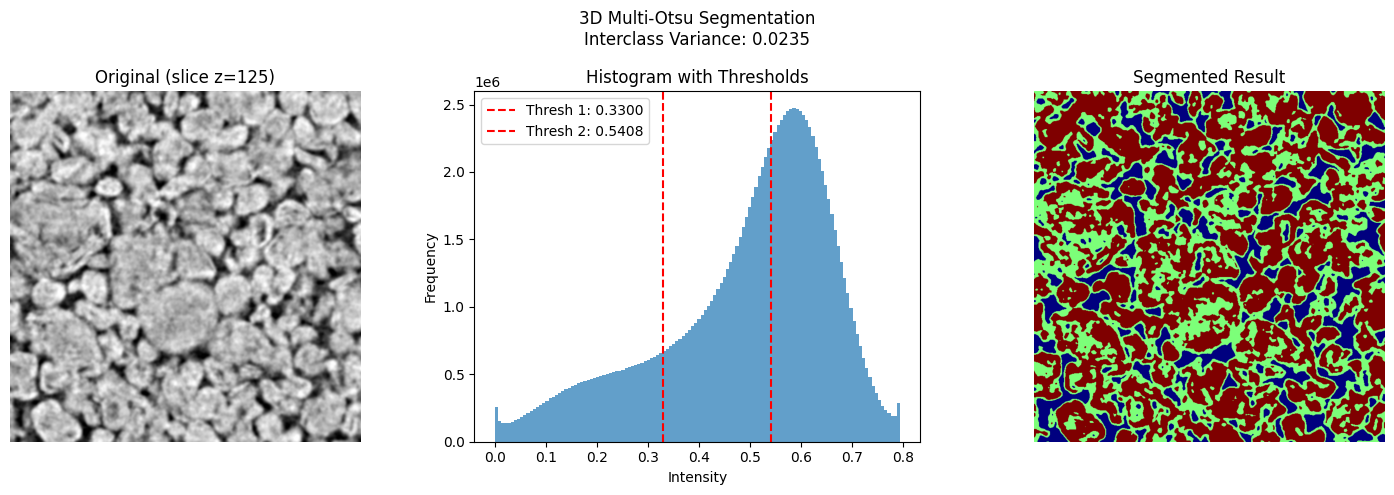

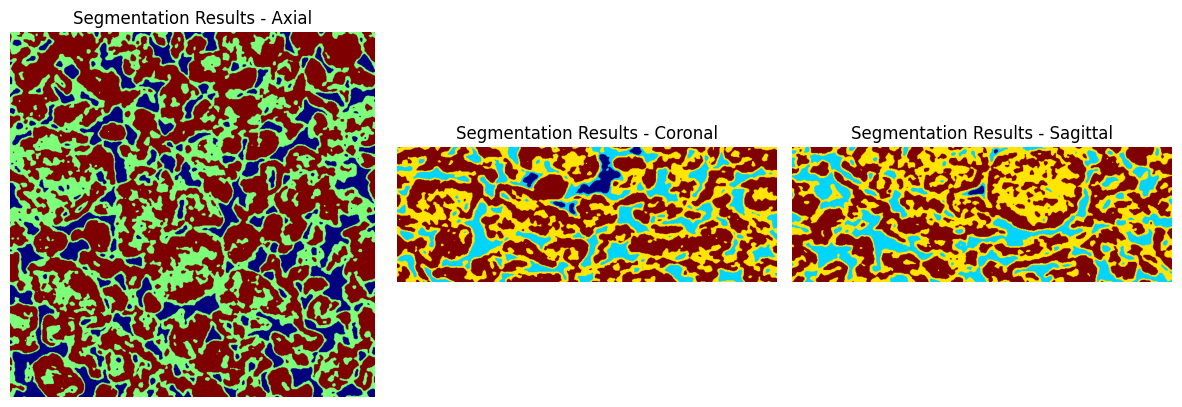

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu, threshold_otsu
from scipy import ndimage
from skimage.morphology import ball
from skimage.measure import label, regionprops


def multi_otsu_3d(volume: np.ndarray, classes: int = 3,
                  min_bg_size: int = 5000, max_bg_size: int = 20000):
    """
    function takes inn: 3D volume (XCT) and:
        Detects low-intensity background region
        Runs multi-otsu on the foreground only
        Assigns class labels to each voxel
        Computes interclass variance as a quality measure
    Returns thresholds, labeled volume, and interclass variance.
    """

    v = volume.astype(np.float32, copy=False)

    # Detect background using Otsu threshold
    try:
        otsu_threshold = threshold_otsu(v)
        background_threshold = otsu_threshold * 0.3
    except:
        background_threshold = np.percentile(v, 2)
# Compute global otsu thershold on the whole volume
    # Create background mask from largest low-intensity region
    low_intensity_mask = v < background_threshold
    background_mask = np.zeros_like(v, dtype=bool)

    if np.any(low_intensity_mask):
        labeled_mask, num_features = ndimage.label(low_intensity_mask)
        if num_features > 0:
            component_sizes = np.bincount(labeled_mask.ravel())
            if len(component_sizes) > 1:
                largest_component = np.argmax(component_sizes[1:]) + 1
                background_candidate = labeled_mask == largest_component

                # Apply size constraints
                region_size = component_sizes[largest_component]
                if min_bg_size <= region_size <= max_bg_size:
                    background_mask = ndimage.binary_dilation(background_candidate, structure=ball(1))
                else:
                    background_mask = low_intensity_mask

    # Segment only foreground regions
    foreground_mask = ~background_mask
    foreground_data = v[foreground_mask]

    if len(foreground_data) == 0:
        # Fallback if no foreground found
        thresholds = threshold_multiotsu(v, classes=classes)
        foreground_mask = np.ones_like(v, dtype=bool)
        foreground_data = v
    else:
        # Apply multi-Otsu to foreground
        thresholds = threshold_multiotsu(foreground_data, classes=classes)

    # Label the volume
    labeled_volume = np.zeros_like(v, dtype=np.uint8)

    # Background gets label 0
    labeled_volume[background_mask] = 0

    # Apply thresholds to foreground regions
    # Class 1: lowest intensity foreground
    mask = foreground_mask & (v <= thresholds[0])
    labeled_volume[mask] = 1

    # Middle classes
    for i in range(1, len(thresholds)):
        mask = foreground_mask & (v > thresholds[i-1]) & (v <= thresholds[i])
        labeled_volume[mask] = i + 1

    # Highest class
    mask = foreground_mask & (v > thresholds[-1])
    labeled_volume[mask] = len(thresholds) + 1

    # Calculate interclass variance
    # Use the class labels directly, not connected components
    unique_labels = np.unique(labeled_volume)
    class_means = []
    class_weights = []

    total_foreground_pixels = np.sum(foreground_mask)
    global_mean = np.mean(foreground_data)

    for label_val in unique_labels:
        if label_val == 0:  # Skip background
            continue
        mask = labeled_volume == label_val
        class_pixels = v[mask]
        if len(class_pixels) > 0:
            class_means.append(np.mean(class_pixels))
            class_weights.append(len(class_pixels) / total_foreground_pixels)

    interclass_variance = 0.0
    for weight, mean in zip(class_weights, class_means):
        interclass_variance += weight * (mean - global_mean) ** 2

    return thresholds, labeled_volume, interclass_variance


# Everything beneath is for outputs (visuals)

def show_segmentation_results(original_volume, segmented_volume, thresholds,
                            interclass_variance, title="3D Multi-Otsu Segmentation"):
    # Show segmentation results with histogram, thresholds, and interclass variance
    z = original_volume.shape[0] // 2
    original_slice = original_volume[z, :, :]
    segmented_slice = segmented_volume[z, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(original_slice, cmap='gray')
    axes[0].set_title(f'Original (slice z={z})')
    axes[0].axis('off')

    # Histogram with thresholds
    axes[1].hist(original_volume.ravel(), bins=128, alpha=0.7)
    axes[1].set_title('Histogram with Thresholds')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Frequency')

    for i, thresh in enumerate(thresholds):
        axes[1].axvline(thresh, color='red', linestyle='--', label=f'Thresh {i+1}: {thresh:.4f}')
    axes[1].legend()

    # Segmented result
    axes[2].imshow(segmented_slice, cmap='jet')
    axes[2].set_title('Segmented Result')
    axes[2].axis('off')

    # Add interclass variance to the title
    plt.suptitle(f'{title}\nInterclass Variance: {interclass_variance:.4f}')
    plt.tight_layout()
    plt.show()

    return fig

def show_3d_views(volume, title=""):
    # Visuals
    z, y, x = volume.shape
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(volume[z//2], cmap='jet')
    axes[0].set_title(f'{title} - Axial')
    axes[0].axis('off')

    axes[1].imshow(volume[:, y//2, :], cmap='jet')
    axes[1].set_title(f'{title} - Coronal')
    axes[1].axis('off')

    axes[2].imshow(volume[:, :, x//2], cmap='jet')
    axes[2].set_title(f'{title} - Sagittal')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
print("3D Multi-Otsu Segmentation with Interclass Variance")

# Using the output from gaussian filter
image = out_gauss  # Replace with actual data

# Run segmentation
thresholds, segmented_volume, interclass_variance = multi_otsu_3d(
    image,
    classes=3,
    min_bg_size=5000,
    max_bg_size=200000
)

# Print required outputs
print("Segmentation results:")
print(f"Thresholds: {thresholds}")
print(f"Classes: {np.unique(segmented_volume)}")
print(f"Voxel counts: {np.bincount(segmented_volume.flatten())}")
print(f"Interclass Variance: {interclass_variance:.4f}")

# Display visualization
show_segmentation_results(image, segmented_volume, thresholds, interclass_variance,
                         "3D Multi-Otsu Segmentation")
show_3d_views(segmented_volume, "Segmentation Results")

# Save the figure
# fig = show_segmentation_results(image, segmented_volume, thresholds, interclass_variance)
# fig.savefig('multi_otsu_results.png', dpi=300, bbox_inches='tight')

In [5]:
import tifffile as tiff

v_litarion = tiff.imread("../results/run_001/Litarion/Litarion_mask.tif")
fill_litarion = tiff.imread("../results/test/litarion/Litarion_mask.tif")
v_tesla = tiff.imread("../results/run_001/Tesla/Tesla_mask.tif")
v_sony = tiff.imread("../results/run_001/Sony_VTC5/Sony_VTC5_mask.tif")
v_sony = tiff.imread("../results/run_001/Sony_VTC5/Sony_VTC5_mask.tif")

show3(v_tesla, "Tesla bin")
show3(raw_tesla, "Tesla Raw")
show3(v_litarion, "Litarion bin")
show3(fill_litarion, "Filled Litarion")
show3(raw_litarion, "Raw Litarion")
show3(v_sony, "Sony bin")
show3(raw_sony, "Sony raw")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ayebe\\CTSeg3D-IKT213\\results\\run_001\\Litarion\\Litarion_mask.tif'